In [1]:
from coosys import cartesian_to_kepler as ctk, cartesian_to_quaternion as ctq
from coosys import kepler_to_cartesian as ktc, quaternion_to_cartesian as qtc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures as PF
from tqdm.auto import tqdm
tqdm.pandas()

from matplotlib import pyplot as plt
%matplotlib inline

D:\Anaconda3\envs\Standard\lib\site-packages\tqdm\std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
base = 1.3885 * 10**9

train_data = pd.read_csv("IDAO 2020/train.csv", encoding="utf8")
train_data["epoch"] = pd.to_datetime(train_data["epoch"]).apply(pd.Timestamp.timestamp) - base

test_data = pd.read_csv("IDAO 2020/Track 1/test.csv", encoding="utf8")
test_data["epoch"] = pd.to_datetime(test_data["epoch"]).apply(pd.Timestamp.timestamp) - base

In [3]:
gamma_km = 398603

def transform_row(row, func):
    return func(row.values)

def transform_dataset(data, func=lambda data: ctk(data, gamma_km), 
                      columns_from=("x", "y", "z", "Vx", "Vy", "Vz"), 
                      columns_to=("a", "e", "inclination", "longitude", "argument", "anomaly")):
    new_data = data.loc[:, list(columns_from)].progress_apply(transform_row, axis=1, result_type="expand", args=(func, ))
    new_data.columns = columns_to
    return data.drop(list(columns_from), axis=1).join(new_data)

In [4]:
train_kepler = transform_dataset(train_data, func=lambda data: ctk(data, gamma_km),
                                 columns_from=("x", "y", "z", "Vx", "Vy", "Vz"),
                                 columns_to=("a", "e", "inclination", "longitude", "argument", "anomaly"))
train_kepler = transform_dataset(train_kepler, func=lambda data: ctk(data, gamma_km), 
                                 columns_from=("x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"),
                                 columns_to=("a_sim", "e_sim", "inclination_sim", "longitude_sim", "argument_sim", "anomaly_sim"))

In [5]:
train_quaternion = transform_dataset(train_data, func=lambda data: ctq(data, gamma_km),
                                     columns_from=("x", "y", "z", "Vx", "Vy", "Vz"),
                                     columns_to=(("a", "e", "anomaly", "q1", "q2", "q3", "q4")))
train_quaternion = transform_dataset(train_quaternion, func=lambda data: ctq(data, gamma_km), 
                                     columns_from=("x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"),
                                     columns_to=("a_sim", "e_sim", "anomaly_sim", "q1_sim", "q2_sim", "q3_sim", "q4_sim"))

In [6]:
def phase_regression(phases):
    periods = 0
    new_phases = phases.copy()
    for i in range(1, phases.size):
        if phases[i] < phases[i - 1]:
            periods += 1
        new_phases[i] += 2 * np.pi * periods
    return new_phases

def phase_degression(phases):
    new_phases = np.zeros_like(phases)
    for i in range(phases.size):
        new_phases[i] = phases[i] - 2 * np.pi * np.trunc(phases[i] / 2 / np.pi) 
    return new_phases

In [7]:
def plot_coordinate(dataset, sat_id, coordinate, time_set=None, transform=lambda x: x,):
    sat_dataset = dataset[dataset.sat_id == sat_id].sort_values("epoch")
    coordinate_set = sat_dataset[coordinate].to_numpy()
    coordinate_sim_set = sat_dataset[coordinate + "_sim"].to_numpy()
    time = sat_dataset["epoch"].to_numpy()
    if time_set is None:
        time_set = (time.min(), time.max())
        
    mask = np.logical_and(time_set[0] <= time, time <= time_set[1])
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], transform(coordinate_set)[mask])
    plt.plot(time[mask], transform(coordinate_sim_set)[mask])
    plt.legend(["true", "approximate"])
    plt.show()
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], transform(coordinate_set)[mask])
    plt.legend(["true"])
    plt.show()
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], transform(coordinate_sim_set)[mask])
    plt.legend(["approximate"])
    plt.show()
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], (transform(coordinate_set) - transform(coordinate_sim_set))[mask])
    plt.legend(["difference"])
    plt.show()

Для всех координат в некоторых случаях наблюдаются выбросы, причем только для точного значения. Возможно, дело в ошибках составления датасета. Также возможен баг преобразования координат.

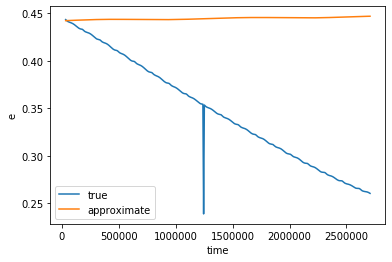

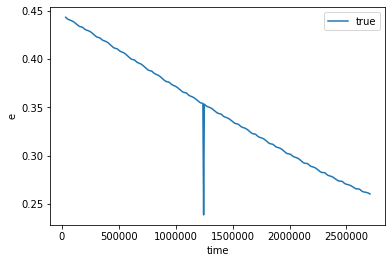

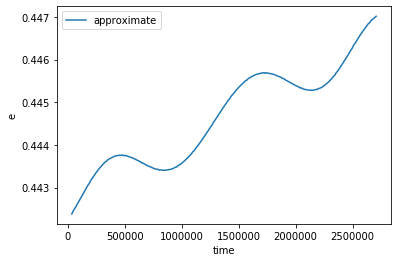

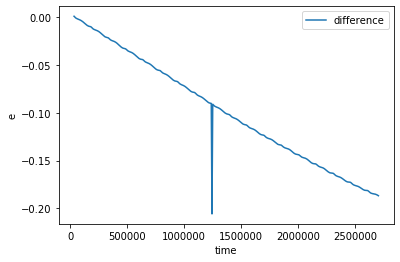

In [8]:
plot_coordinate(train_kepler, 6, "e")

Координата "a", соответствующая большей полуоси, почти не подвержена дрейфу, но заметно осциллирует (с периодом, соответствующим периоду обращения, и разными формами кривых для разных спутников). При этом, амплитуда колебаний зависит от времени (либо в виде монотонного возрастания (убывания), либо в виде биений, либо в виде модуляции; вероятно, в принципе эта координата переходит от биений к модуляции, но для выделения всей эволюции не хватает масштаба). Приближенная модель немного отличается по равновесному значению, совершенно не ловит дрейфа и показывает осцилляции заметно меньшей (и постоянной) амплитуды и другой формы.

Модуляции:

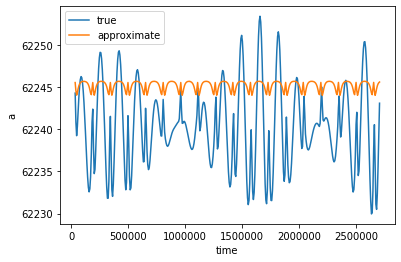

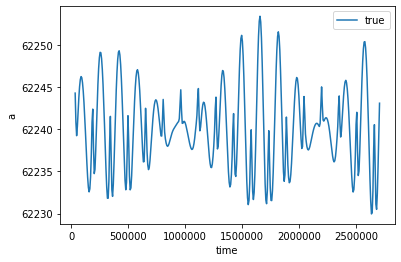

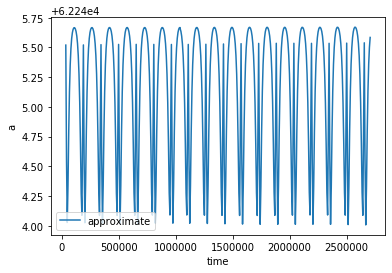

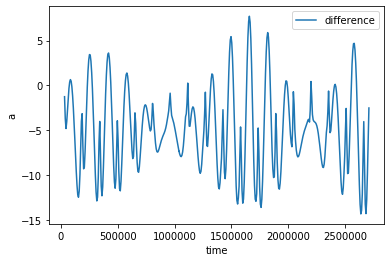

In [9]:
plot_coordinate(train_kepler, 2, "a")

Биения:

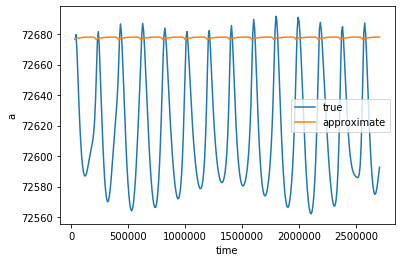

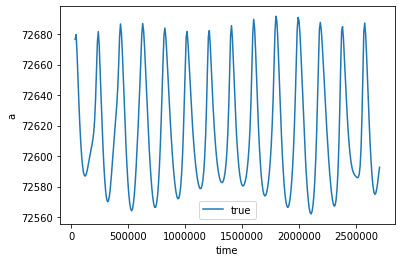

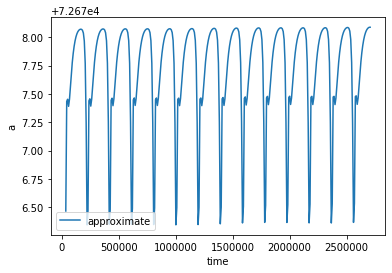

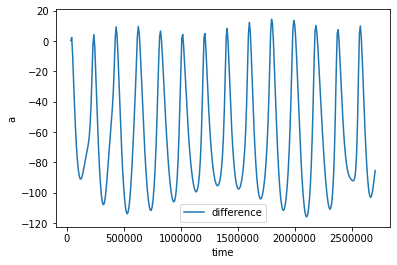

In [10]:
plot_coordinate(train_kepler, 9, "a")

Дрейф (и постоянная амплитуда):

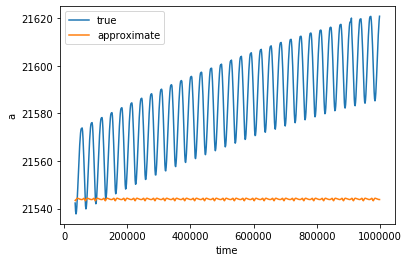

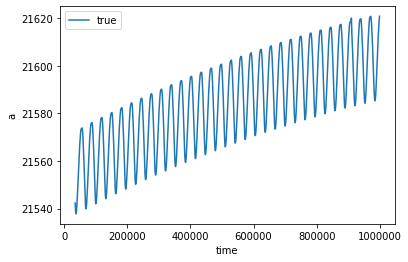

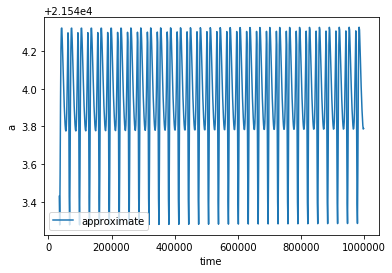

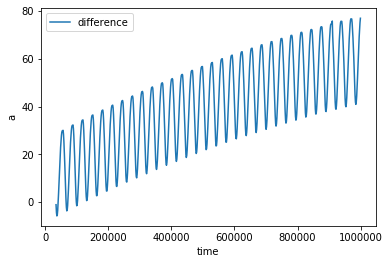

In [11]:
plot_coordinate(train_kepler, 11, "a", (0, 1000000))

Монотонная зависимость амплитуды от времени:

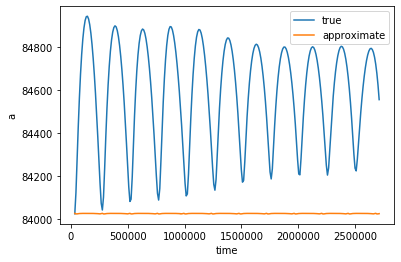

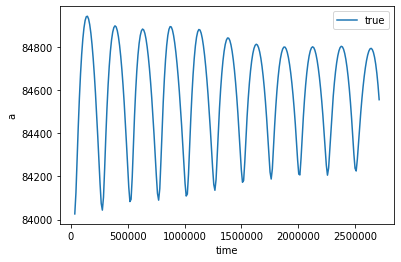

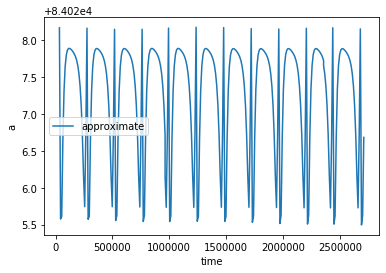

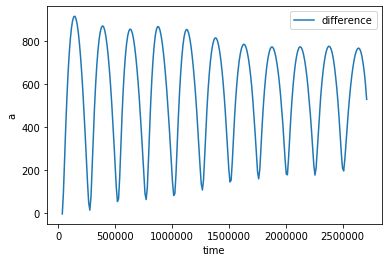

In [12]:
plot_coordinate(train_kepler, 22, "a")

Координата "e", соответствующая экцентриситету, имеет сложную зависимость от времени, включая как дрейф, так и осцилляции (но амплитуда осцилляций постоянна и невелика). В отличие от прочих координат, дрейф для этой координаты бывает нелинейным и существенным, однако масштаба не хватает, чтобы определить, является ли изменения колебанием с большим периодом. При этом, приближенная модель иногда ловит зависимость координаты от времени с промахом по среднему значению (для малых изменений), но зачастую практически не ловит дрейфа. Кроме того, приближенная модель не всегда попадает в осцилляции, но из-за их небольшой амплитуды это несущественно.

Отличие на константу:

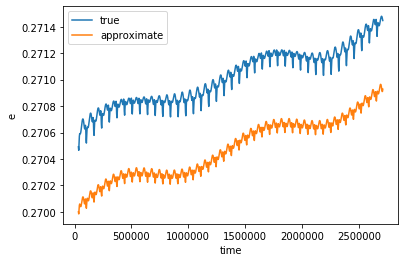

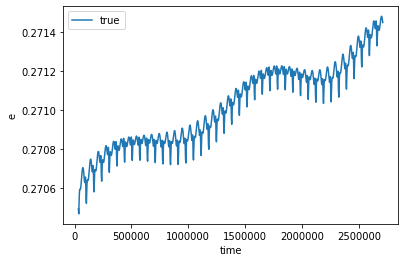

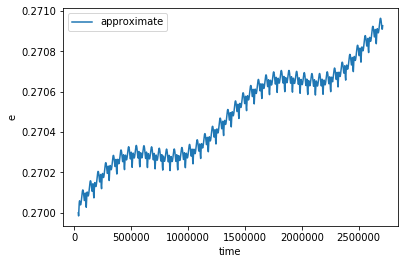

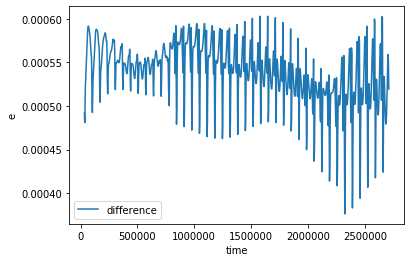

In [13]:
plot_coordinate(train_kepler, 0, "e")

Существенный, практически линейных дрейф:

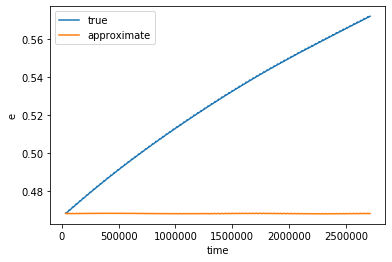

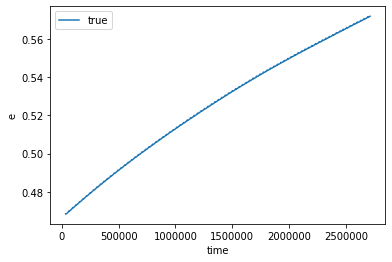

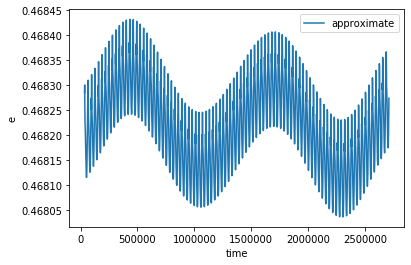

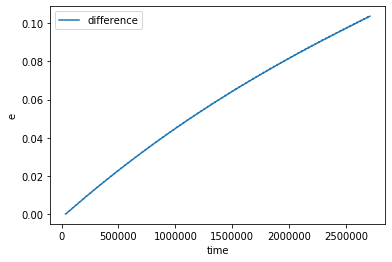

In [14]:
plot_coordinate(train_kepler, 1, "e")

Отличие на константу и дрейф:

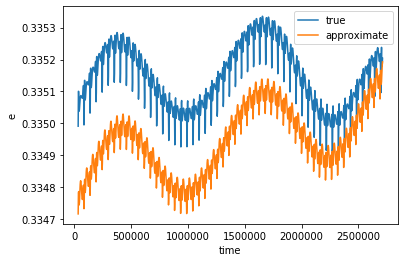

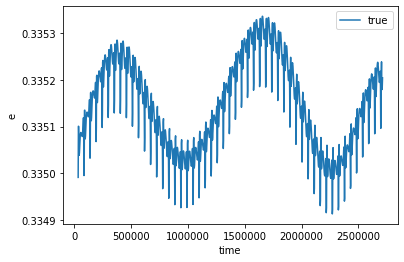

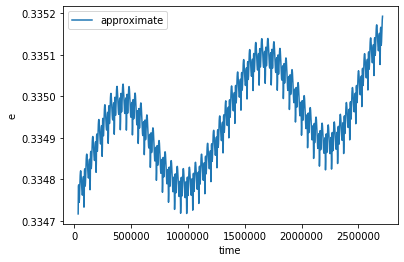

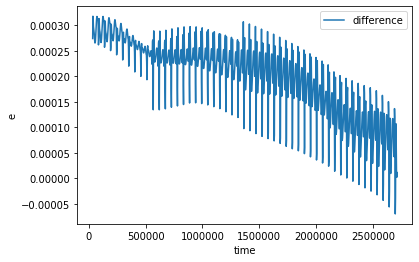

In [15]:
plot_coordinate(train_kepler, 4, "e")

Параболическая (или синусоидальная - неопределимо) зависимость:

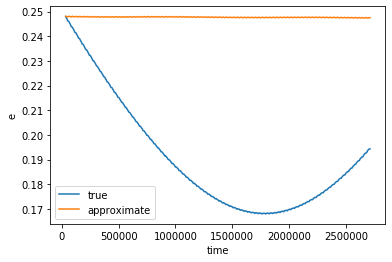

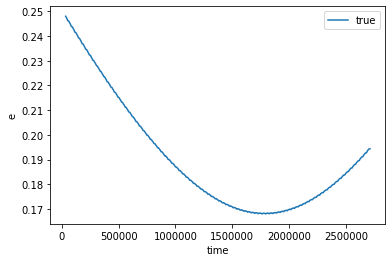

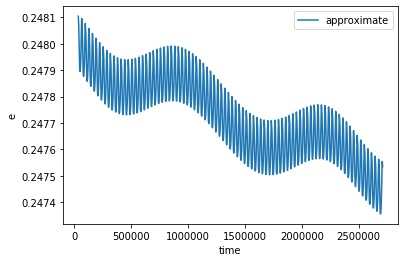

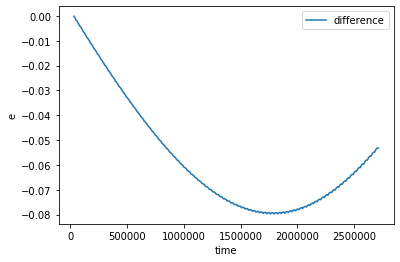

In [16]:
plot_coordinate(train_kepler, 11, "e")

Координата "anomaly", соответствующая аномалии положения (углу между перигеем и текущим положением), судя по всему, вносит основной вклад в ошибку предсказания координаты. Зависимость аномалии от времени сложная и периодическая, поэтому будет рассматриваться именно разница с приближенным значением, с учетом выпрямления координаты (т.е. перевода её из ограниченной отрезком от 0 до 2 пи в непрерывную кривую). Видно, что эта разница дрейфует и осциллирует с изменяющейся амплитудой и кривой сложной формы (и периодом, соответствующим периоду обращения), причем и среднее, и амплитуда могут изменяться скачкообразно. Помимо этого, разница может выходить не из нуля. Возможно, это происходит из-за дрейфа сдвига по фазе, и предпочтительной будет попытка найти сдвиг как anomaly(t) = anomaly_sim(f(t)).

Скачкообразные дрейф и изменение амплитуды (с небольшим непрерывным дрейфом и того, и другого):

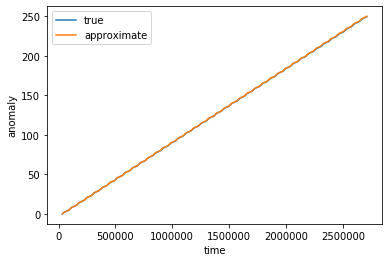

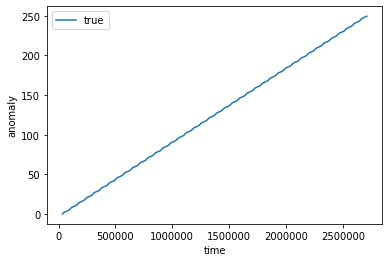

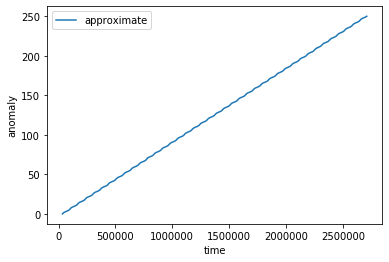

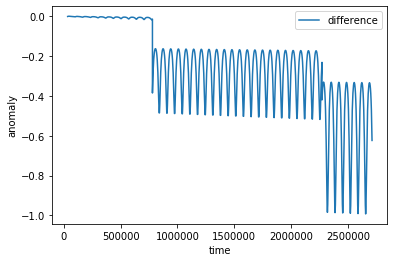

In [17]:
plot_coordinate(train_kepler, 0, "anomaly", transform=phase_regression)

Непрерывные дрейф и рост амплитуды:

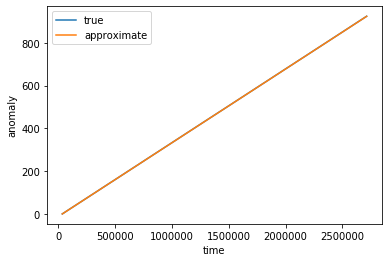

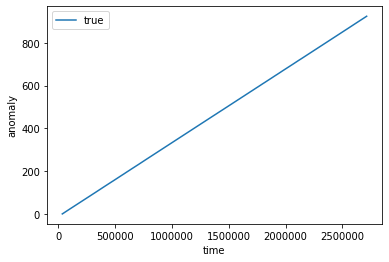

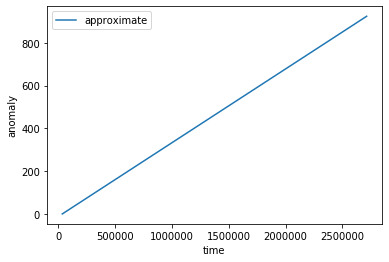

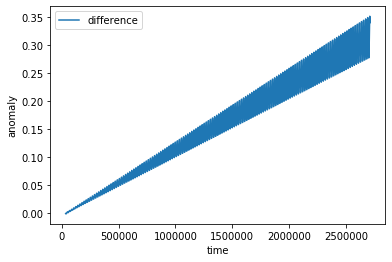

In [18]:
plot_coordinate(train_kepler, 5, "anomaly", transform=phase_regression)

Нелинейный дрейф:

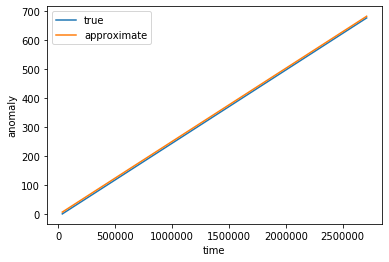

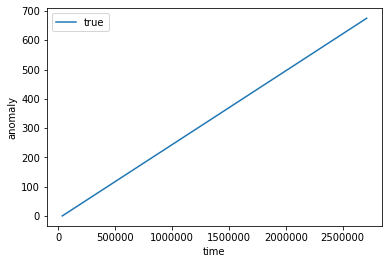

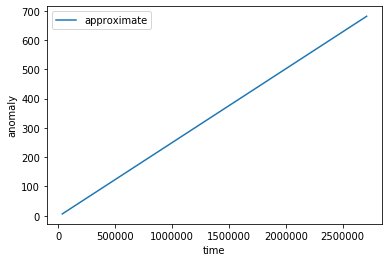

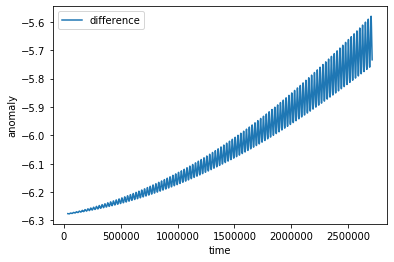

In [19]:
plot_coordinate(train_kepler, 8, "anomaly", transform=phase_regression)

Нелинейный дрейф среднего и амплитуды:

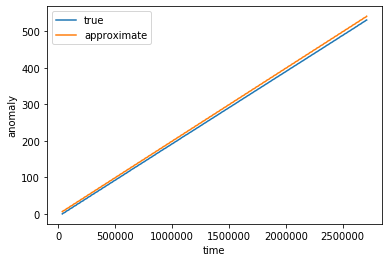

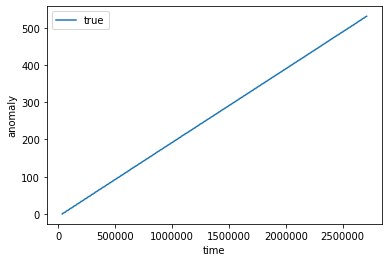

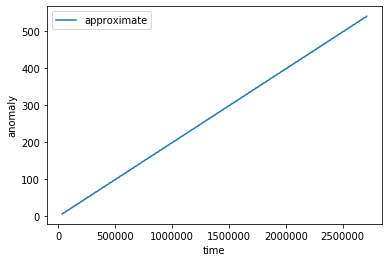

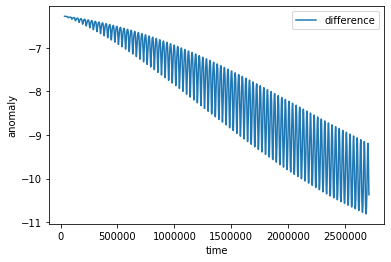

In [20]:
plot_coordinate(train_kepler, 11, "anomaly", transform=phase_regression)

Прочие координаты ("longitude", "inclination", "argument" для элементов орбиты и "q1", "q2", "q3", "q4" для кватернионов) от времени зависят слабо. Эта зависимость выражается в осцилляциях с периодом обращения и постоянной небольшой амплитудой, а также в небольшом дрейфе. При этом, приближение часто не ловит дрейфа и зачастую отличается на константу в случае, когда дрейфа нет. В целом, зависимости для кватернионных координат проще в случае существенного дрейфа (однако попадаются сложные зависимости в случае небольшого дрейфа).

Координата "longitude", ничтожная разница между приближенным и истинным значениями.

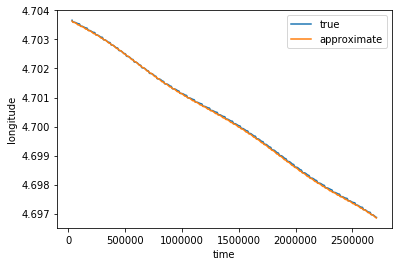

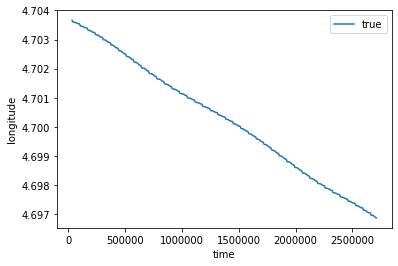

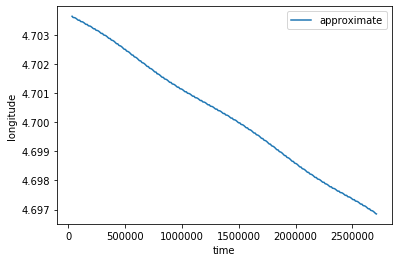

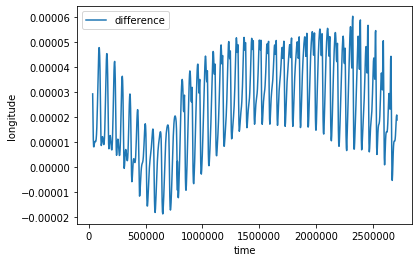

In [21]:
plot_coordinate(train_kepler, 0, "longitude")

Координата "inclination", разница на константу:

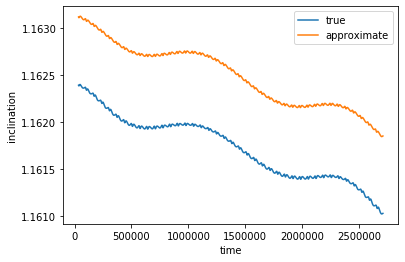

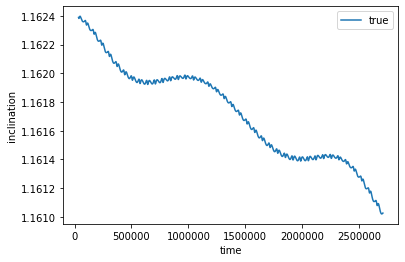

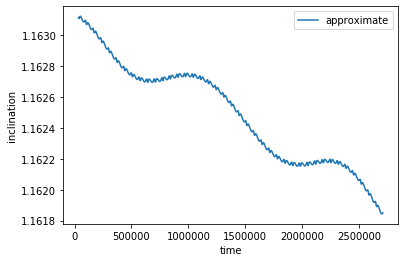

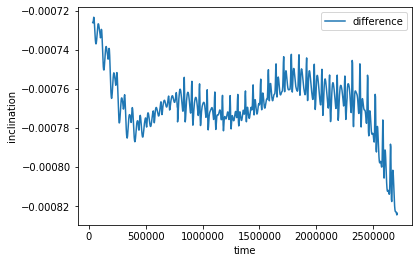

In [22]:
plot_coordinate(train_kepler, 0, "inclination")

Координата "argument", не учтенный приближенной моделью существенный дрейф:

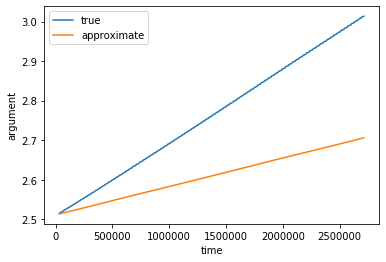

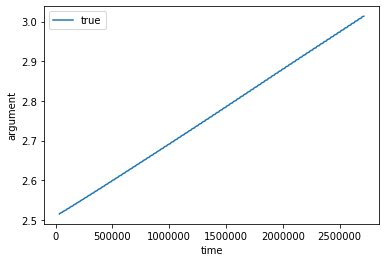

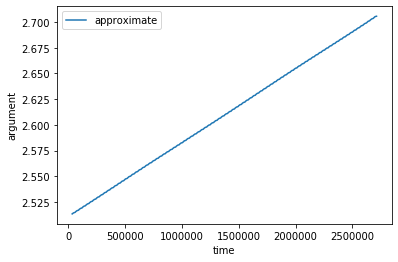

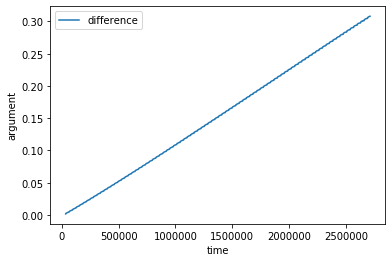

In [23]:
plot_coordinate(train_kepler, 1, "argument")

Координата "q1", неучтенный приближенной моделью нелинейный дрейф:

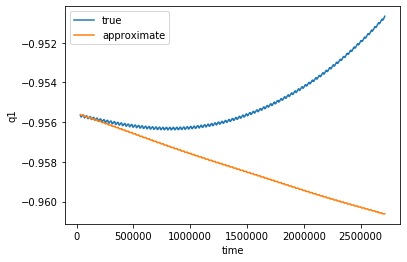

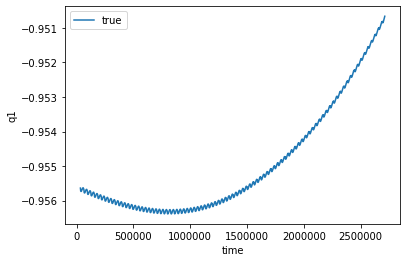

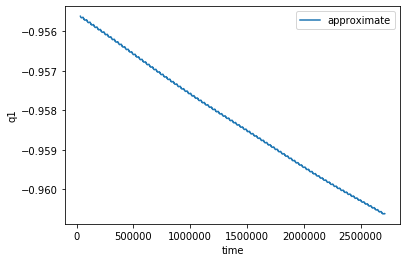

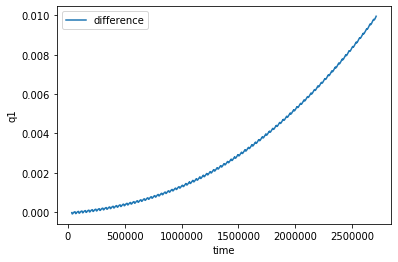

In [24]:
plot_coordinate(train_quaternion, 1, "q1")

Координата "q2", параболический дрейф (и выброс):

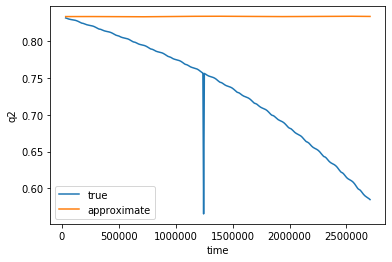

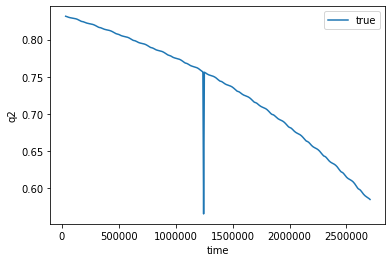

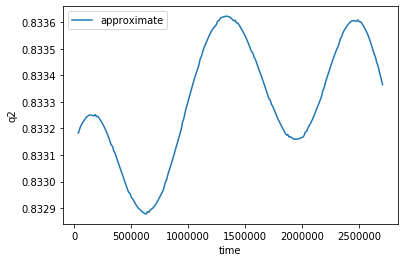

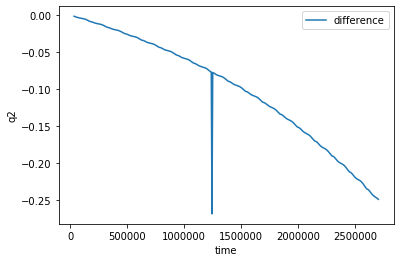

In [25]:
plot_coordinate(train_quaternion, 6, "q2")

Координата "q3", сложная зависимость (может быть приближена полиномом):

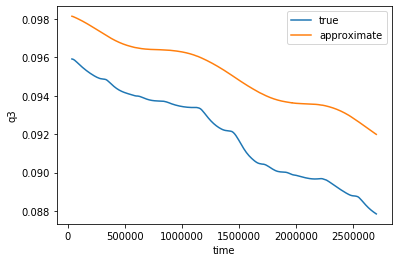

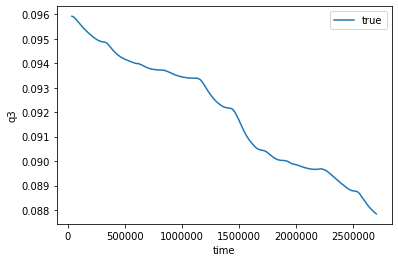

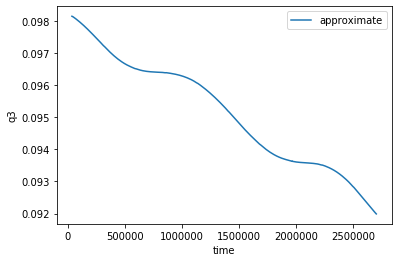

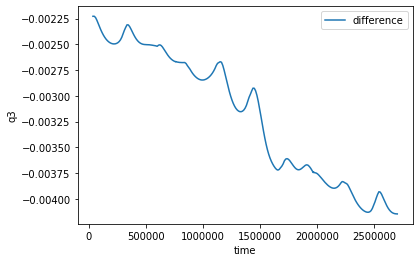

In [26]:
plot_coordinate(train_quaternion, 7, "q3")

Координата "q4", дрейф вместе с отличием на константу:

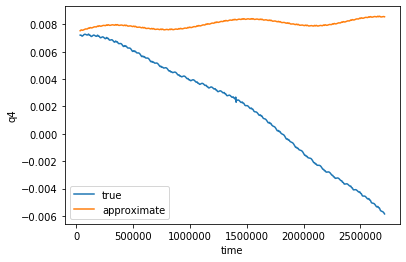

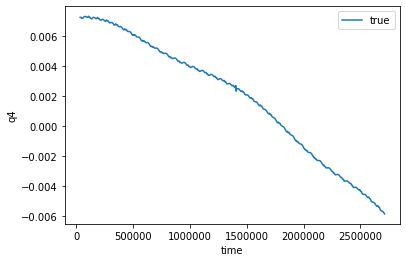

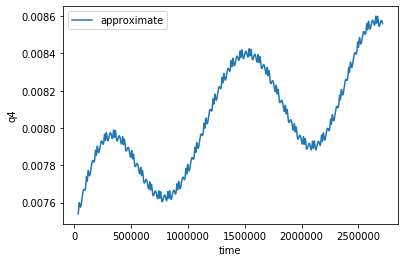

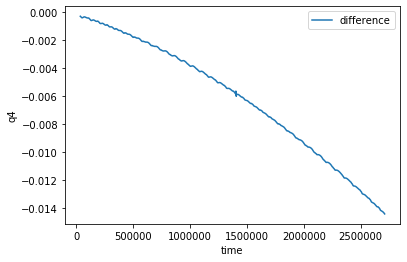

In [27]:
plot_coordinate(train_quaternion, 14, "q4")